<a href="https://colab.research.google.com/github/deniz997/MoviePosterClassification/blob/master/DL_MoviePoster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
We will classify movies by genres, based on their posters. Beside that, it is also aimed in this project to examine the effect of style transfer on this multilabel-classification.

# Introduction
<small>Genre classification for movies, a type of multilabel-classification, is well used in industry. Such companies like Netflix, Amazon etc. use this functionality to deliver their contents, to whom it may attract. Beyond static genres, they even produce dynamic(combined) genres. Netflix also generates dynamic posters for their contents, accordingly to consumers interests. Based on this feature, we can say that posters are very important for attracting consumers and also they inform the consumer about the content of the product. Some posters might lead its consumer wrong, and this might cause time waste and disappointment. Dynamic posters of Netflix are mostly based on the objects, and do not represent the style of the genre, movie belongs. This project might lead a future work to see the effect of style transfer on poster based movie genre classifier and by comparing this effect with a survey, with some audience and maybe lead a future work of making this dynamic posters better.

The input to our algorithm is a database of movie poster images and their genres. We then use a neural network to predict movie genres.</small>

# Dataset
<small>The database ["Movie Genre from its Poster" from Kaggle](https://www.kaggle.com/neha1703/movie-genre-from-its-poster) is used in this project.It contains information about movies, such as IMDB id, IMDB link, title, IMDB score and the link of the poster of the movie.
Data is pre-processed similarly as [Rahul et al.(2020)](http://cs230.stanford.edu/projects_winter_2020/reports/32643471.pdf)'s work. After pre-processing the database and the retrieval of the movie posters, a movie poster image dataset, consists of 36898 268X182 resolution RGB posters, is obtained. Dataset contains 28 different genres, resulting a high imbalance on the dataset. To overcome this problem, we have determined genres with a threshold of 4500 examples per genre. 28 different genres are then reduced to top 6 most popular genres. For the movies, belong to a genre that is not in our list, we have created an extra column called 'Others' and set it to 1.

At the end we have the pre-processed data that the algorithm requires. Yet, the data is not equally distributed, and this limits the expected accuracy.</small>

# Install Libraries and setup environment

In [1]:
%load_ext tensorboard
from google.colab import drive
from google.colab import files
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
import ast
from pandas.io.json import json_normalize
from sklearn.metrics import f1_score, hamming_loss,accuracy_score, confusion_matrix
from sklearn.utils import class_weight

In [2]:
# import Keras&Tensorflow libraries
import keras
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.metrics import binary_crossentropy
import tensorflow as tf
from keras.regularizers import l1
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet169
from keras.models import load_model

Using TensorFlow backend.


In [3]:
#Check tensorflow version
print(tf.__version__)

2.2.0


Define helper functions

In [4]:
def mount_drive():
  drive.mount('/content/drive')

def write_and_download_csv(filename):
  dataset.to_csv(filename, index = False) 
  files.download(filename)

#Get genres from genre representing array
def arrayToGenre(movie_genre_array, genre_to_use):
  genres = []
  for i in range(movie_genre_array.size):
    if movie_genre_array[i] == 1:
      genres.append(genre_to_use[i])
  return genres

def openImageWithSize(img_path, width, height):
  img = image.load_img(img_path, target_size=(width,height,3))
  img = image.img_to_array(img)
  img = img/255.0
  plt.imshow(img)

def getSinglePred(imgPath, arr,model):
  x = arrayToGenre(arr, genre_to_use)
  img = image.load_img(imgPath, target_size=(img_width,img_height,3))
  img = image.img_to_array(img)
  img = img/255.0
  single_pred = model.predict(np.expand_dims(img, axis=0))
  max_preds = np.argsort(single_pred)
  threshold = (single_pred>0.3)
  max_three = [genre_to_use[i] for i in max_preds[0][len(genre_to_use)-3:]]
  return x, max_three, threshold

def plotModel(filename):
  tf.keras.utils.plot_model(
    model,
    to_file=filename,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
  )

In [ ]:
mount_drive()

Extract posters from posters.zip file and install GPU for hardware accelerator

`!unzip -q "path_to_zip_file" -d "path_to_file_to_extract"`

In [6]:
!unzip -q /content/drive/My\ Drive/Movie\ Genre\ Classification/posters.zip -d /content/Images

In [ ]:
!pip -q install tensorflow-gpu==2.0.0-rc0

# Data Pre-Processing
Load cleaned dataset and genres, that will be predicted

In [8]:
data = pd.read_csv('/content/drive/My Drive/Movie Genre Classification/movie_genre.csv')
genre_to_use = ['Action','Comedy','Drama','Romance','Crime','Thriller','Other']
data.shape

(39140, 2)

Create list of multihot-encoded vectors from genres

In [9]:
liste = []
for i in data['Genre']:
  liste.append(ast.literal_eval(i))
bin_list = []
for x in liste:
  tempArray = np.zeros((len(genre_to_use)))
  tempArray.astype(int)
  for label in x:
    if label in genre_to_use:
      tempArray[genre_to_use.index(label)]=1
    else:
      tempArray[len(genre_to_use)-1] = 1
  bin_list.append(tempArray)

Create new dataset and set genre as a multihot-encoded array, so that every element of the array will be an integer (1 or 0)

In [10]:
data_use = pd.DataFrame({'imdbId':data['imdbId'],'Genre':bin_list})
data_use['imdbId'] = data_use['imdbId'].astype(int)

In [11]:
data_use['Genre'] = data_use['Genre'].apply(lambda x: x.astype(int))

**Example**
Get genres of a poster for testing from multihot-encoded vector

In [12]:
img_ind = 2
x=arrayToGenre(data_use['Genre'][img_ind], genre_to_use)
print(x)#genres with label
print(data_use['Genre'][img_ind]) #genres-multihot-encoded

['Comedy', 'Romance']
[0 1 0 1 0 0 0]


Convert multihot-encoded vectors to labeled dataframe
<br><small>-This might take a couple of seconds</small>


In [13]:
genre_matrix = np.zeros((len(genre_to_use),data_use['Genre'].shape[0]))

for i in range(len(genre_to_use)):
  for row in range(data_use['Genre'].shape[0]):
    data = data_use['Genre'][row][i]
    if data == 1:
      genre_matrix[i][row] = 1
    elif data == 0:
      genre_matrix[i][row] = 0

Create a dataframe with genres and set genre columns to the array that we just extracted in the last step.
> *You can always change the number of genres by altering this DataFrame. But also you need to configure the array "genre_to_use" in this step.*



In [14]:
dataset = pd.DataFrame(
    {
        "imdbId":data_use['imdbId'],
        "Action":genre_matrix[0],
        "Comedy":genre_matrix[1],
        "Drama":genre_matrix[2],
        "Romance":genre_matrix[3],
        "Crime":genre_matrix[4],
        "Thriller":genre_matrix[5],
        "Other":genre_matrix[6]
    }
)

Get path of every poster
<br><small>Because the files are created from this dataset, we know that length and the index of the files must match with the dataset. Therefore we can set the path accordingly.</small>


In [15]:
posters_path = '/content/Images/posters/'
path_list = []
ind = 0
for i in range(len(os.listdir(posters_path))):
  path = posters_path+str(i)
  for img in range(len(os.listdir(path))):
    img_path = path + '/' + str(data_use['imdbId'][ind])+'.jpg'
    path_list.append(img_path)
    ind = ind + 1
print(ind)

39140


Copy dataset and set 'imdbId' as filepaths of posters

In [16]:
df = dataset.copy()
df['imdbId'] = path_list
df[:35226] = df[:35226].sample(frac=1).reset_index(drop=True)

Here you can examine the dataset by setting a genre property to 1 to see how many examples with that genres exist. 

In [ ]:
only_other = df.where(df['Other']==0).where(df['Action']==0).where(df['Comedy']==0).where(df['Crime']==0).where(df['Drama']==0).where(df['Romance']==0).where(df['Thriller']==0).dropna()
only_other.shape

(0, 8)

Examine the dataset, by comparing train and test data in the aspect of the number of examples per genre<br>
<small>You can see the imbalance of the dataset</small>

In [17]:
counts_of_genres = []
test_splitter = df.shape[0]-int((df.shape[0]/100)*10)

for i in range(df.columns.size-1):
  counts_of_genres.append(df[:test_splitter].loc[df[:test_splitter].iloc[:,i+1]==1].shape[0])

counts_of_genres_test = []

for i in range(df.columns.size-1):
  counts_of_genres_test.append(df[test_splitter:].loc[df[test_splitter:].iloc[:,i+1]==1].shape[0])

counts_of_genres_total = []

for i in range(df.columns.size-1):
  counts_of_genres_total.append(df.loc[df.iloc[:,i+1]==1].shape[0])

gen_counts = pd.DataFrame(list(zip(genre_to_use,counts_of_genres, counts_of_genres_test, counts_of_genres_total)),columns = ['Genre','Count(Train)','Count(Test)','Total'])
gen_counts


,Genre,Count(Train),Count(Test),Total
0,Action,4824,469,5293
1,Comedy,11413,1105,12518
2,Drama,17968,1820,19788
3,Romance,5723,445,6168
4,Crime,4862,372,5234
5,Thriller,4352,435,4787
6,Other,19663,2177,21840


#Generator specs
<small>Model has an input size of 150 x 150 x 3 as image width, image height and color channels respectively. I chose mini-batch size of 128 and with that such relatively big mini-batch size I aimed to improve the generalization of the network. Decision threshold was 0,3 and all of these parameters were found through a heuristic approach and gave the best results within an acceptable computation time.<br>Distribution of examples is as 31704 train set, 3522 val set, 3914 test set.
Then posters are transferred in to the resolution of 150X150.</small>
<br><br>Create dataflow and data generators

In [18]:
img_width = 150
img_height = 150
batch_size_tr = 128
seed_tr = 42
train_val_split = 0.1
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_splitter = df.shape[0]-int((df.shape[0]/100)*10)

train_datagen=ImageDataGenerator(validation_split=train_val_split)
test_datagen=ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
dataframe = df.iloc[:test_splitter],
directory=None,
x_col="imdbId",
y_col=genre_to_use,
batch_size=batch_size_tr,
seed=seed_tr,
shuffle=True,
subset="training",
class_mode="raw",
target_size=(img_width,img_height))

validation_generator = train_datagen.flow_from_dataframe(
dataframe = df.iloc[:test_splitter],
directory=None,
x_col="imdbId",
y_col=genre_to_use,
batch_size=batch_size_tr,
seed=seed_tr,
shuffle=True,
subset="validation",
class_mode="raw",
target_size=(img_width,img_height))

test_generator=test_datagen.flow_from_dataframe(
dataframe = df.iloc[test_splitter:],
directory=None,
x_col="imdbId",
y_col=genre_to_use,
batch_size=1,
seed=seed_tr,
shuffle=False,
class_mode="raw",
target_size=(img_width,img_height))

Found 31704 validated image filenames.
Found 3522 validated image filenames.
Found 3914 validated image filenames.


# Usage
<small>Set from_scratch to True, then set parameters according to the model, that you want to retrieve its weights.Then set from_scratch to False and run cell again to lock this cell with its parameters and model set.<br>
# Build modified ResNet-50 model
I have implemented a standard ResNet-50 architecture with some modifications, similar to the modifications proposed by [Rahul Chokshi and Samuel Sung](http://cs230.stanford.edu/projects_winter_2020/reports/32643471.pdf).
Because the model is based on the ResNet-50, I used it via Keras Applications API.The final fully connected layer of 1000 units of this base model was replaced by 3 sequential fully connected layers of 1024, 128 and 7 units. These layers use ReLu, ReLu and sigmoid activations.
I used sigmoid activation instead of softmax activation, because softmax divides the probability among the classes, which is helpful, when the input belongs to only one class, in contrast to multilabel-classification.</small><br>
# Loss Function

<small>As another result of that I used Binary-Crossentropy as a loss function.Binary-Crossentropy measures how far the predictions from the true value for each class and averages the class-wise error to calculate the final loss of a prediction.In order to deal with the imbalance of the dataset, class weights were implemented by using a built-in Keras function. During the training class weights are set as balanced. This built-in functionality calculates the weight of each class, according to its occurrence in the dataset</small>

# Metric

<small>As a metric I used built-in accuracy from Keras. Therefore Keras decides the best accuracy metric to use, according to the shape of the output. In this example it uses Binary Accuracy and calculates how far the predictions from the ground thruth vector. But because the examples in the dataset contains maximum 3 positive values (1), the accuracy is more than %70, even if it assigns a negative value (0) for each example.To overcome this issue, the results are examined below by F1-Score, calculated for each genre.</small>

In [ ]:
from_scratch = False
unfrozen = True

if from_scratch:
      base_model = ResNet50(
        weights = 'imagenet',
        include_top = False,
        pooling = 'max',
        input_shape = (img_height,img_width,3),
      )
      if unfrozen:
        base_model.trainable=True
      else:
        for layer in base_model.layers:
          layer.trainable = False
        for layer in base_model.layers[-40:]:
          layer.trainable = True
      inputs = keras.Input(shape=(img_height, img_width, 3))
      x = base_model(inputs)
      x = Dense(1024, activation = 'relu')(x)
      x = Dense(128, activation = 'relu')(x)
      outputs = Dense(len(genre_to_use),activation='sigmoid')(x)
      model = keras.Model(inputs, outputs)

Load weigths of the model, you have built.

In [ ]:
if not from_scratch:
  model.load_weights('/content/drive/My Drive/Movie Genre Classification/model_adam-e10-resnet-unfreez-imagenet.h5')

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 903       
Total params: 25,817,991
Trainable params: 25,764,871
Non-trainable params: 53,120
_________________________________________________________________


Compile model and create log file for Tensorboard


In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Train model
<br><small>To overcome the imbalance of the dataset I set class_weight to balanced. So that Keras automatically calculates the class weights, according to their occurence in the dataset.</small>

In [ ]:
if from_scwratch:
  history = model.fit_generator(generator=train_generator,epochs=10,class_weight='balanced',validation_data=validation_generator,callbacks=[tensorboard_callback])

Save model after training

In [ ]:
if from_scratch:
  model.save('/content/drive/My Drive/Movie Genre Classification/model_adam-e20-resnet-unfreez40-imagenet.h5')

Get predictions

In [ ]:
test_generator.reset()
pred=model.predict(x=test_generator,
verbose=1)

3914/3914 [==============================] - 69s 18ms/step


Evaluate model and get test accuracy

In [ ]:
test_generator.reset()
metrics = model.evaluate(x=test_generator)

3914/3914 [==============================] - 72s 18ms/step


In [ ]:
print('Test accuracy: {:5.2f}%'.format(100*metrics[1]))
print('Test loss: ' + str(metrics[0]))

Test accuracy: 74.58%
Test loss: 1.5695059299468994


Get max 3 predictions

In [ ]:
results=pd.DataFrame(pred, columns=genre_to_use)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+genre_to_use
results=results[ordered_cols]

res_holder = results.drop(columns=['Filenames'])
res_with_3max = pd.DataFrame(res_holder.columns.values[np.argsort(-res_holder.values, axis=1)[:, :3]], 
                  index=res_holder.index,
                  columns = ['1st Max','2nd Max','3rd Max']).reset_index()
res_with_3max['imdbId']=results['Filenames']
res_with_3max = res_with_3max.drop(columns=['index'])
res_with_3max

In [ ]:
threshold = 0.3
pred_bool = (pred >= threshold)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=genre_to_use)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+genre_to_use
results=results[ordered_cols]

Groundtruth: ['Other']
Predicted with probability threshold: ['Drama', 'Other']
Top 3 Predictions: ['Drama' 'Other' 'Action']


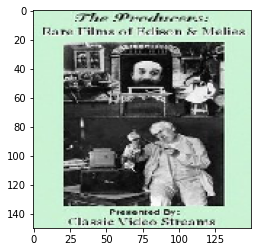

In [ ]:
random_test_data = results.sample()
pred_path = np.array(random_test_data['Filenames'])
pred_path = pred_path[0]
openImageWithSize(pred_path,img_width,img_height)

truth_row = df.loc[df['imdbId']==pred_path].drop(columns=['imdbId']).to_numpy()
truth_labels = arrayToGenre(truth_row[0],genre_to_use)
print("Groundtruth: "+str(truth_labels))

pred_with_th = np.array(results.loc[results['Filenames']==pred_path].drop(columns='Filenames'))
print("Predicted with probability threshold: " + str(arrayToGenre(pred_with_th[0],genre_to_use)))

pred_row = res_with_3max.loc[res_with_3max['imdbId']==pred_path].drop(columns='imdbId').to_numpy()
print("Top 3 Predictions: "+ str(pred_row[0]))

Groundtruth: ['Other']
Top 3 prediction: ['Drama', 'Thriller', 'Other']
Prediction with threshold: ['Thriller', 'Other']


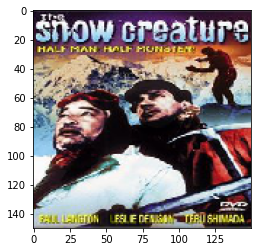

In [ ]:
random_train_data = df[:35226].sample()
pred_path = np.array(random_train_data['imdbId'])
truth = np.array(df.loc[df['imdbId']==pred_path[0]].drop(columns='imdbId'))
ground_truth, max_preds, threshold = getSinglePred(pred_path[0],truth[0],model);
openImageWithSize(pred_path[0],img_width,img_height)

print('Groundtruth: ' + str(ground_truth))
print('Top 3 prediction: ' + str(max_preds))
print('Prediction with threshold: ' + str(arrayToGenre(threshold[0],genre_to_use)))

In [ ]:
df_score = df.iloc[test_splitter:].drop(columns=['imdbId']).apply(lambda x: x.astype(int))
res_score = results.drop(columns=['Filenames']).apply(lambda x: x.astype(int))
score = f1_score(df_score,res_score, average=None)
score= (score*100).round(decimals=2)
score_df = pd.DataFrame(list(zip(genre_to_use,score)))
print("F1-Score: ")
print(score_df)

avg = f1_score(df_score,res_score, average='weighted')
print('Weigthed average of F1-Score: ' + str(avg))

hamming = hamming_loss(df_score,res_score)
print("Hamming Loss: " + str(hamming))

acc_score = accuracy_score(df_score,res_score)
print("Accuracy score: " + str(acc_score*100))

print("Genre, TN, FP, FN, TP")
for i in range(len(genre_to_use)):
  tn, fp, fn, tp = confusion_matrix(y_true = np.array(df_score.iloc[:,i]), y_pred = np.array(res_score.iloc[:,i])).ravel()
  print(genre_to_use[i], tn, fp, fn, tp)

F1-Score: 
          0      1
0    Action  29.12
1    Comedy  43.39
2     Drama  60.21
3   Romance  23.10
4     Crime  20.00
5  Thriller  25.64
6     Other  69.52
Hamming Loss: 0.2987444339002847
Accuracy score: 8.993357179356156
Genre, TN, FP, FN, TP
Action 2623 822 249 220
Comedy 2095 714 601 504
Drama 789 1305 474 1346
Romance 3064 405 334 111
Crime 3059 483 277 95
Thriller 2921 558 289 146
Other 331 1406 268 1909
0.5150278312436037


Examine the graphs and the metrics of the deep neural networks

In [ ]:
%tensorboard --logdir drive/My\ Drive/CNNModels/logs/fit

Plot model diagramm

In [ ]:
plotModel("model_graph.png")